##Our Task is to predict the coordinates of fixed size pokemon that appear against a black background, only one type of pokemon

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
#downloading pokemon image
!wget -nc https://lazyprogrammer.me/course_files/charmander-tight.png

--2022-05-27 04:49:22--  https://lazyprogrammer.me/course_files/charmander-tight.png
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3952 (3.9K) [image/png]
Saving to: ‘charmander-tight.png’

charmander-tight.pn 100%[===================>]   3.86K  --.-KB/s    in 0s      

2022-05-27 04:49:22 (47.3 MB/s) - ‘charmander-tight.png’ saved [3952/3952]



In [ ]:
#while reading from image it contain only 3 channel despite being png file
from tensorflow.keras.preprocessing import image
poke = image.load_img('charmander-tight.png')
image.img_to_array(poke).shape

(56, 44, 3)

(56, 44, 4)


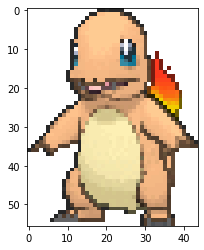

In [ ]:
from imageio import imread
obj = imread('charmander-tight.png')
print(obj.shape)
plt.imshow(obj)

In [ ]:
#while reading from imageio.imread, since this file is png so it contain transparency
np.unique(obj[:,:,3])

Array([  0, 255], dtype=uint8)

In [ ]:
#Created and loaded model with input image of size (200,200,3) 
dim = 200 #pixels in image
obj_h, obj_w, _ = obj.shape
image_size = (dim,dim,3)
vgg = VGG16(include_top=False, weights='imagenet', input_shape=image_size)
x = Flatten()(vgg.output)
x = Dense(4, activation='sigmoid')(x)
model = tf.keras.Model(inputs=vgg.input, outputs=x)
model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                              

In [ ]:
def get_image():
    x = np.zeros(image_size, dtype=float)  #image pixel value
    y = np.zeros(4, dtype=float)  #top-left coordinate and height and width, (row,col,height,width) within range [0,dim)
    row0 = np.random.randint(0, dim-obj_h)
    col0 = np.random.randint(0, dim-obj_w)
    x[row0:row0+obj_h,col0:col0+obj_w,:] = obj[:,:,:3] #assigning slice of image to pokemon
    y[0], y[1], y[2], y[3] = row0, col0, obj_h, obj_w
    return x, y

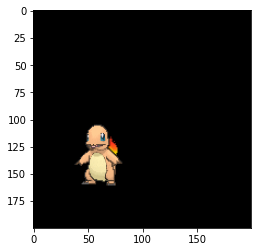

In [ ]:
x,y = get_image()
plt.imshow(x/255.)

In [ ]:
num_batches = 50
batch_size = 64
def my_generator():
    while True:
        for _ in range(num_batches):
            X = np.zeros((batch_size,) + image_size, dtype=float)
            Y = np.zeros((batch_size, 4), dtype=float)
            for i in range(batch_size):
                X[i],Y[i] = get_image()
            yield X/255.,Y/dim

In [ ]:
model.compile(Adam(learning_rate=0.0003), loss='binary_crossentropy', metrics='mse')
history = model.fit(my_generator(), epochs=10, steps_per_epoch=num_batches)

Epoch 1/10
50/50 [==============================] - 55s 666ms/step - loss: 0.5922 - mse: 0.0135
Epoch 2/10
50/50 [==============================] - 35s 695ms/step - loss: 0.5544 - mse: 1.4426e-04
Epoch 3/10
50/50 [==============================] - 34s 685ms/step - loss: 0.5546 - mse: 3.7372e-05
Epoch 4/10
50/50 [==============================] - 34s 684ms/step - loss: 0.5527 - mse: 2.0194e-05
Epoch 5/10
50/50 [==============================] - 34s 689ms/step - loss: 0.5523 - mse: 2.0432e-05
Epoch 6/10
50/50 [==============================] - 34s 685ms/step - loss: 0.5536 - mse: 1.5402e-05
Epoch 7/10
50/50 [==============================] - 34s 687ms/step - loss: 0.5548 - mse: 9.6247e-06
Epoch 8/10
50/50 [==============================] - 34s 689ms/step - loss: 0.5527 - mse: 9.6019e-06
Epoch 9/10
50/50 [==============================] - 35s 691ms/step - loss: 0.5554 - mse: 1.3543e-05
Epoch 10/10
50/50 [==============================] - 34s 688ms/step - loss: 0.5525 - mse: 1.1604e-05


In [ ]:
def make_single_prediction():
    x,y = get_image()

    #Prediction of white box coordinates by model
    y_pred = model.predict(np.expand_dims(x/255., axis=0))[0]
    y_pred = np.array(np.round(y_pred*dim), dtype=int)

    #Plot predicted white box on image
    fig, ax = plt.subplots(1)
    ax.imshow(x/255.)
    rect = Rectangle((y_pred[1], y_pred[0]), y_pred[3], y_pred[2], edgecolor='r', facecolor='none', linewidth=1)
    ax.add_patch(rect)
    plt.show()

    #Computing Intersection over union
    y[2], y_pred[2] = y[0]+y[2], y_pred[0]+y_pred[2]
    y[3], y_pred[3] = y[1]+y[3], y_pred[1]+y_pred[3]
    common = max(0,min(y[2],y_pred[2])-max(y[0],y_pred[0]))*max(0,min(y[3],y_pred[3])-max(y[1],y_pred[1]))
    total_area = (y_pred[2]-y_pred[0])*(y_pred[3]-y_pred[1]) + (y[2]-y[0])*(y[3]-y[1]) - common
    iou = common/total_area
    print(f'Intersection over union : {round(iou,3)}')

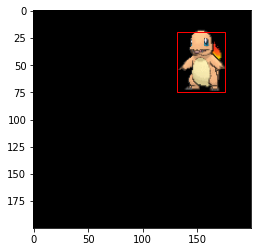

Intersection over union : 0.923


In [ ]:
make_single_prediction()

In [ ]:
def batch_prediction():
    #Generating batch of images
    X = np.zeros((batch_size,) + image_size, dtype=float)
    Y = np.zeros((batch_size, 4), dtype=float)
    for i in range(batch_size):
        X[i],Y[i] = get_image()
    y_pred = model.predict(X/255.)
    y_pred = np.round(y_pred*dim)

    #Computing intersection over union over batch of images
    height = np.maximum(np.minimum(Y[:,0]+Y[:,2],y_pred[:,0]+y_pred[:,2])-np.maximum(Y[:,0],y_pred[:,0]),0)
    width = np.maximum(np.minimum(Y[:,1]+Y[:,3],y_pred[:,1]+y_pred[:,3])-np.maximum(Y[:,1],y_pred[:,1]),0)
    common = height*width
    total = Y[:,2]*Y[:,3] + y_pred[:,2]*y_pred[:,3] - common
    iou = common/total
    return iou

Mean of Intersection over union over 64 batch images : 0.954
Standard deviation of Intersection over union over 64 batch images : 0.027


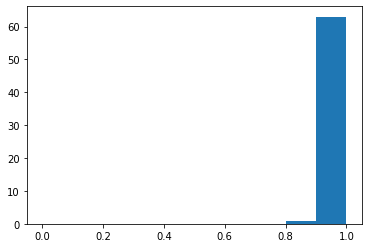

In [ ]:
#Distribution of iou on single batch prediction
iou = batch_prediction()
plt.hist(iou, bins=10, range=(0,1))
print(f'Mean of Intersection over union over 64 batch images : {round(iou.mean(),3)}')
print(f'Standard deviation of Intersection over union over 64 batch images : {round(iou.std(),3)}')

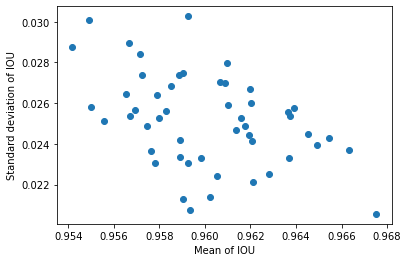

In [ ]:
#Plotting how generalize our model is
iou_mean, iou_std = [],[]
for i in range(num_batches):
    iou = batch_prediction()
    iou_mean.append(iou.mean())
    iou_std.append(iou.std())
plt.xlabel('Mean of IOU')
plt.ylabel('Standard deviation of IOU')
plt.scatter(iou_mean, iou_std)